In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 44.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import tqdm
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

import sklearn

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
torch.cuda.is_available()

True

# 1. Optuna: Optimize hyperparameters <a name="p1"></a>

### Grid Search vs Random Search

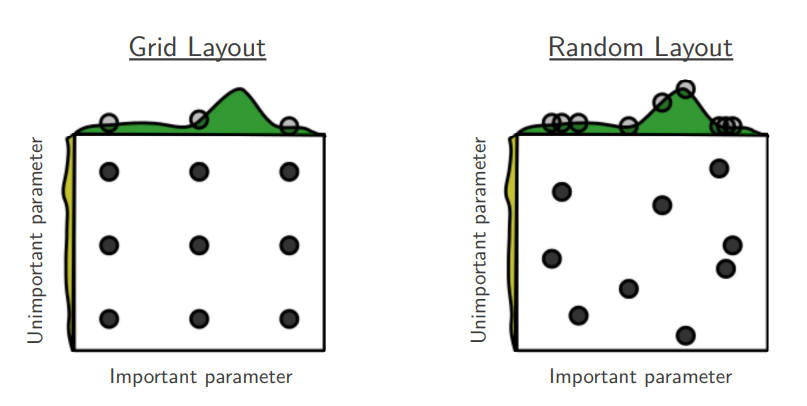

### Random Search vs Optuna

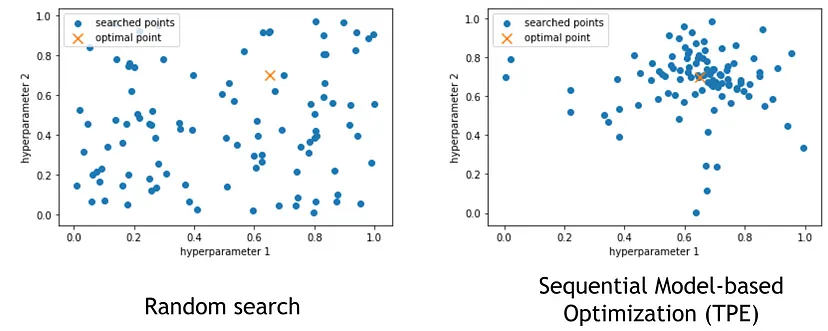

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.7 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

# пример фунции objective
def objective(trial):
    """
    objective для optuna - инициализирует и учит 1 модель и возвращает ее метрику (то, что оптимизирует optuna)
    """
    # optuna сэмплирует гиперпараметры модели
    C = trial.suggest_float('C', low=1e-3, high=1e3, log=True)

    # инициализируем модель
    model = LogisticRegression(C=C)

    #  учим
    model.fit(X_train, y_train)

    # получаем предикт
    y_pred = model.preidct(X_test)

    # возращаем метрику
    return accuracy_score(y_test,y_pred )


## 1.1. sample model params <a name="p1_1"></a>

In [ ]:
import torch_geometric
from torch_geometric.nn import GCNConv, SAGEConv, GATConv

from torch.nn import Linear, Sequential, Dropout, ReLU, LeakyReLU, PReLU
import torch.nn.functional as F

In [ ]:
def sample_model_params(trial):
    """
    Randomly generates params for GenerealGNN
    """
    model_params = {}
    # activation function
    model_params['activation'] = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'PReLU'] )

    # type of graph convolution
    model_params['conv_class'] = trial.suggest_categorical('conv_class', ['GCNConv', 'SAGEConv', 'GATConv'] )

    # hidden size
    model_params['hidden_size'] = trial.suggest_int('hidden_size', low=16, high=256,log=True)

    # probabily for dropout
    model_params['p_dropout'] = trial.suggest_float('p_dropout', low=0, high=0.5)


    # whether to apply linear layer before graph convolutions or not
    model_params['use_linear_before'] = trial.suggest_categorical('use_linear_before', [False, True])

    # whether to apply linear layer after graph convolutions or not
    model_params['use_linear_after'] = trial.suggest_categorical('use_linear_after', [False, True])


    return model_params

## 1.2. Model class <a name="p1_2"></a>

In [ ]:
class GeneralGNN(torch.nn.Module):
    def __init__(self,
                 conv_class,
                 activation,
                 input_size,
                 hidden_size,
                 output_size,
                 p_dropout,
                 use_linear_before = False,
                 use_linear_after = False):
        super(GeneralGNN, self).__init__()
        torch.manual_seed(420)

        self.use_linear_before = use_linear_before
        self.use_linear_after = use_linear_after

        ConvClass = getattr(torch_geometric.nn, conv_class)
        Activation = getattr(torch.nn, activation)

        conv1_input_size = hidden_size if self.use_linear_before else input_size
        conv2_output_size = hidden_size if self.use_linear_after else output_size

        # линейный слой до GNN для предобрабтки фичей
        if self.use_linear_before:
            self.lin_before = Sequential(
                    Linear(input_size, hidden_size),
                    Activation(),
                    Dropout(p_dropout),
            )

        ##### основгая часть GNN
        self.conv1 = ConvClass(conv1_input_size, hidden_size, aggr='mean')
        self.act1 = Activation()
        self.dropout1 = Dropout(p_dropout)
        self.conv2 = ConvClass(hidden_size, conv2_output_size, aggr='mean')
        #####


        # линейный слой после GNN для постобработки фичей
        if self.use_linear_after:
            self.lin_after = Sequential(
                    Activation(),
                    Dropout(p_dropout),
                    Linear(hidden_size, output_size),

            )


    def forward(self, x, edge_index):
        if self.use_linear_before:
            x = self.lin_before(x)

        x = self.conv1(x, edge_index)
        x = self.act1(x)
        x = self.dropout1(x)
        x = self.conv2(x, edge_index)

        if self.use_linear_after:
            x = self.lin_after(x)

        return x

## 1.3. Objective <a name="p1_3"></a>

In [ ]:
def objective(trial):
    """
    objective для optuna - инициализирует и учит 1 модель и возвращает ее метрику (то, что оптимизирует optuna)
    """
    model_params = sample_model_params(trial)
    weight_decay = trial.suggest_float('weight_decay', low=1e-7, high=1e-3, log=True)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model_params['input_size'] = data.x.shape[1]
    model_params['output_size'] = len(data.y.unique())

    model = GeneralGNN(**model_params)
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer = optimizer,
        milestones =  [15, 30],
        gamma = 0.25)


    # RUN Training 1 model
    best_accuracy = 0
    n_epochs = 10
    for epoch in tqdm.tqdm(range(1, n_epochs+1)):
        total_loss = train(model, loader_train, criterion, device, optimizer, tqdm_disable=True)
        test_acc = test(model, loader_test, device, tqdm_disable=True)
        best_accuracy = max(best_accuracy, test_acc)


        # Optinal, you may prune Unpromising Trials
        trial.report(best_accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.TrialPruned()


    return best_accuracy

### Pruning Unpromising Trials

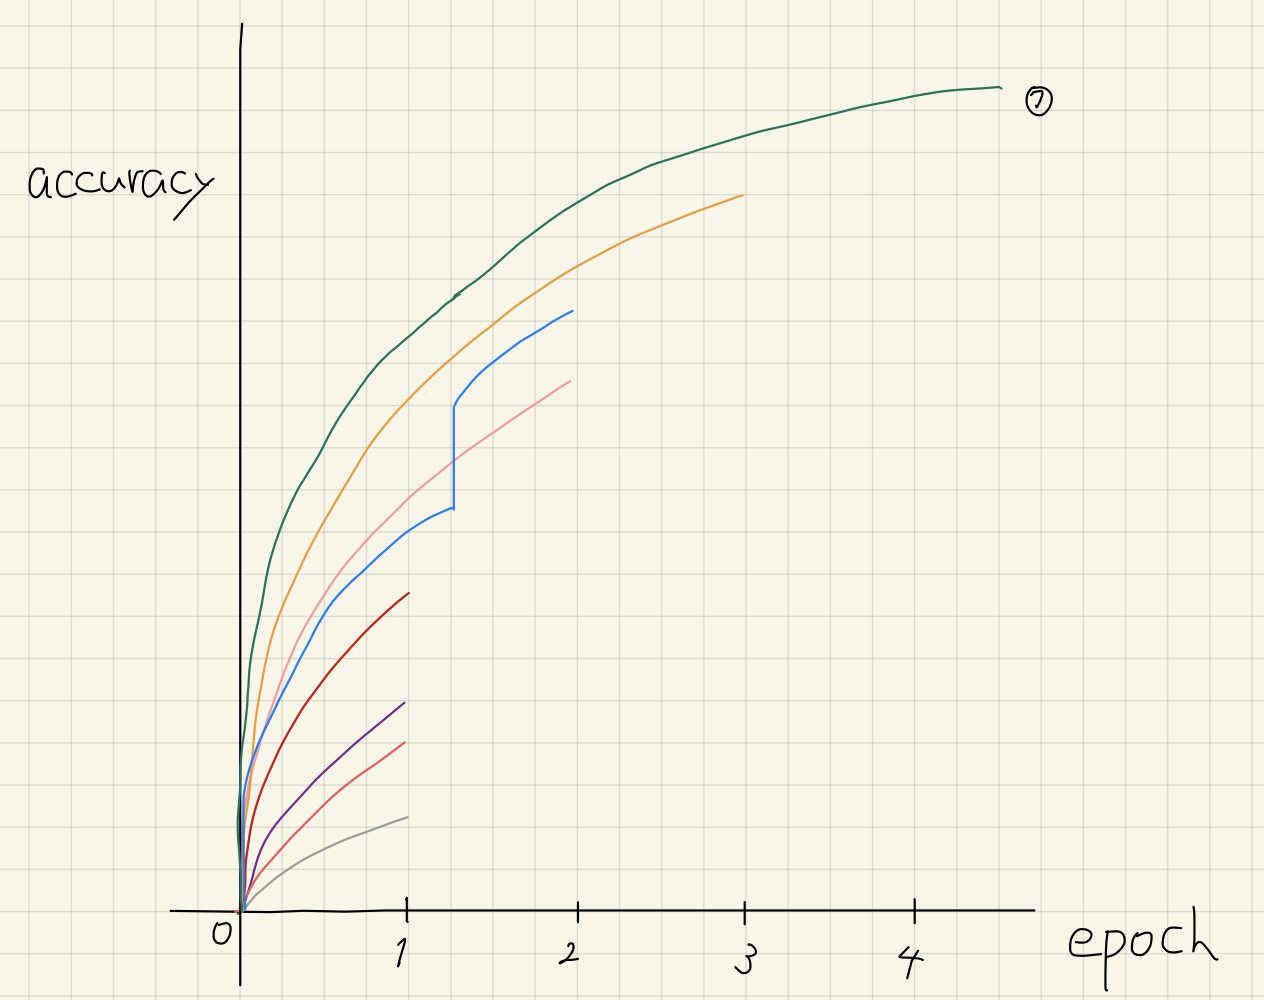

In [ ]:
def train(model, loader, criterion, device, optimizer, scheduler=None, tqdm_disable=True):
    """
    train model for 1 epoch
    """
    start_time = time.time()

    model.train()
    total_loss = 0

    for data_batch in tqdm.tqdm(loader, leave=False, disable=tqdm_disable):
        sampled_data = data_batch.clone().to(device)

        optimizer.zero_grad()
        out = model(x = sampled_data.x, edge_index = sampled_data.edge_index)
        loss = criterion(out[:sampled_data.batch_size], sampled_data.y[:sampled_data.batch_size])
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        total_loss += loss.detach().item() / len(loader)

    if scheduler is not None:
        scheduler.step()

    calc_time = time.time() - start_time
    return total_loss



def test(model, loader, device, tqdm_disable=True):
    """
    eval model
    """
    start_time = time.time()

    model.eval()

    ys = []
    outs = []

    with torch.no_grad():
        for data_batch in tqdm.tqdm(loader, leave=False, disable=tqdm_disable):
            sampled_data = data_batch.clone().to(device)

            out = model(x = sampled_data.x, edge_index = sampled_data.edge_index).detach()
            ys.append(sampled_data.y[:sampled_data.batch_size].cpu())
            outs.append(out[:sampled_data.batch_size].cpu())


    out = torch.cat(outs, dim=0)
    y = torch.cat(ys)

    y_pred = out.argmax(dim=1)

    calc_time = time.time() - start_time

    # accuracy
    return (y==y_pred).float().mean().item()

## 3.4. RUN <a name="p3_4"></a>

In [ ]:
def describe_data(data):
    print('========================')

    print(f'Number of nodes: {data.x.shape[0]}')
    print(f'Number of edges: {data.edge_index.shape[1]}')
    print(f'Number of features: {data.x.shape[1]}')

    if data.edge_attr is not None:
        print(f'Number of edge attributes: {data.edge_attr.shape[1]}')

    y = data.y.numpy()
    y = y[~np.isnan(y) & (y!=-100)]
    print(f'Number of classes: {len(np.unique(y))}')
    print('========================')

In [ ]:
from torch_geometric.datasets import Amazon
dataset = Amazon(root='data/Amazon', name='Computers')

data = dataset[0]

describe_data(data)

Processing...


Number of nodes: 13752
Number of edges: 491722
Number of features: 767
Number of classes: 10


Done!


In [ ]:
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(torch.arange(len(data.x)), test_size=0.25, random_state=42)

from torch_geometric.loader import NeighborLoader
from torch_geometric.data import Data

loader_train = NeighborLoader(
    data,
    num_neighbors=[20, 10],
    batch_size=250,
    shuffle=False,
    input_nodes=train_idx,
)


loader_test = NeighborLoader(
    data,
    num_neighbors=[20, 10],
    batch_size=250,
    shuffle=False,
    input_nodes=test_idx,
)


In [ ]:
import optuna

In [ ]:
study = optuna.create_study(
    direction = 'maximize',
    sampler = optuna.samplers.TPESampler(seed=10),
    pruner = optuna.pruners.MedianPruner()
)

[I 2023-12-07 11:16:17,880] A new study created in memory with name: no-name-32bdcd28-581d-49dd-ad75-b3dfa2220a28


In [ ]:
study.optimize(objective, n_trials=5)

100%|██████████| 10/10 [00:38<00:00,  3.86s/it]
[I 2023-12-07 11:16:56,495] Trial 0 finished with value: 0.7987201809883118 and parameters: {'activation': 'ReLU', 'conv_class': 'GCNConv', 'hidden_size': 27, 'p_dropout': 0.38026535609947937, 'use_linear_before': False, 'use_linear_after': True, 'weight_decay': 1.0370341671327118e-07}. Best is trial 0 with value: 0.7987201809883118.
100%|██████████| 10/10 [00:41<00:00,  4.12s/it]
[I 2023-12-07 11:17:37,720] Trial 1 finished with value: 0.6864455938339233 and parameters: {'activation': 'LeakyReLU', 'conv_class': 'GATConv', 'hidden_size': 115, 'p_dropout': 0.27127218400563063, 'use_linear_before': True, 'use_linear_after': False, 'weight_decay': 5.445728346977895e-06}. Best is trial 0 with value: 0.7987201809883118.
100%|██████████| 10/10 [00:43<00:00,  4.40s/it]
[I 2023-12-07 11:18:21,707] Trial 2 finished with value: 0.8929610252380371 and parameters: {'activation': 'PReLU', 'conv_class': 'SAGEConv', 'hidden_size': 198, 'p_dropout': 0.15

In [ ]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_activation,params_conv_class,params_hidden_size,params_p_dropout,params_use_linear_after,params_use_linear_before,params_weight_decay,state
0,0,0.798720,2023-12-07 11:16:17.888494,2023-12-07 11:16:56.494838,0 days 00:00:38.606344,ReLU,GCNConv,27,0.380265,True,False,1.037034e-07,COMPLETE
1,1,0.686446,2023-12-07 11:16:56.497662,2023-12-07 11:17:37.719764,0 days 00:00:41.222102,LeakyReLU,GATConv,115,0.271272,False,True,5.445728e-06,COMPLETE
2,2,0.892961,2023-12-07 11:17:37.724364,2023-12-07 11:18:21.707015,0 days 00:00:43.982651,PReLU,SAGEConv,198,0.159618,True,True,1.540229e-07,COMPLETE
3,3,0.892379,2023-12-07 11:18:21.713760,2023-12-07 11:19:04.574817,0 days 00:00:42.861057,PReLU,SAGEConv,129,0.147981,True,False,2.365056e-07,COMPLETE
4,4,0.901396,2023-12-07 11:19:04.576567,2023-12-07 11:19:47.741274,0 days 00:00:43.164707,ReLU,SAGEConv,157,0.125687,True,True,1.435910e-07,COMPLETE


In [ ]:
study.optimize(objective, n_trials=1)

100%|██████████| 10/10 [00:41<00:00,  4.19s/it]
[I 2023-12-07 11:21:23,236] Trial 5 finished with value: 0.8979057669639587 and parameters: {'activation': 'ReLU', 'conv_class': 'SAGEConv', 'hidden_size': 52, 'p_dropout': 0.15746343592134415, 'use_linear_before': False, 'use_linear_after': True, 'weight_decay': 0.00011296979705718801}. Best is trial 4 with value: 0.9013961553573608.


# 2. CoolGraph <a name="p2"></a>

Мы с коллегами из МТС разработали библиотеку CoolGraph  

CoolGraph is an easy-to-use Python library with Graph Neural Networks for node classification.  
The CoolGraph contains several architectures that will help you train a network using two lines of code.

Звездочки приветствуются  
https://github.com/MobileTeleSystems/CoolGraph/tree/main

In [ ]:
!pip install optuna
!pip install omegaconf==2.3.0
!pip install hydra-core==1.3.2
!pip install loguru==0.6.0
!pip install mlflow==2.1.1

!pip install cool-graph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=0a4e5e107185e741f95ca3740857659b905982ff251b3570e7ae1408e56cc853
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 kB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 96.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.9 MB/s eta 0:00:00
  Created wheel for cool-graph: filename=cool_graph-0.0.1-py3-none-any.whl size=39030 sha256=062339c9248c9255352fd20c3157d2a32cf3917a6dd28a74e435457b22d06af9
  Stored in directory: /root/.cache/pip/wheels/08/d0/75/7676b782f3430a761df8444a87346d202c2eed2c1cf9daec4c
Successfully built cool-graph
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.3.3 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=

In [ ]:
1

1

## 2.1. Easy run <a name="p2_1"></a>

In [ ]:
# Load Dataset
from torch_geometric import datasets
data = datasets.Amazon(root='./data/Amazon', name='Computers').data

In [ ]:
# Train GNN model
from cool_graph.runners import Runner
runner = Runner(data)
result = runner.run()

Sample data: 100%|██████████| 14/14 [00:05<00:00,  2.59it/s]
2023-12-07 11:24:12.740 | INFO     | cool_graph.train.trainer:train:230 - 
Epoch 000: 
2023-12-07 11:24:13.095 | INFO     | cool_graph.train.helpers:eval_epoch:179 - test:
 {'accuracy': 0.579, 'cross_entropy': 1.105, 'f1_weighted': 0.503, 'calc_time': 0.006, 'main_metric': 0.579}
2023-12-07 11:24:13.097 | INFO     | cool_graph.train.trainer:train:257 - Epoch 000: 
2023-12-07 11:24:14.084 | INFO     | cool_graph.train.helpers:eval_epoch:179 - train:
 {'accuracy': 0.59, 'cross_entropy': 1.076, 'f1_weighted': 0.517, 'calc_time': 0.016, 'main_metric': 0.59}
2023-12-07 11:24:22.923 | INFO     | cool_graph.train.trainer:train:230 - 
Epoch 005: 
2023-12-07 11:24:23.295 | INFO     | cool_graph.train.helpers:eval_epoch:179 - test:
 {'accuracy': 0.886, 'cross_entropy': 0.367, 'f1_weighted': 0.878, 'calc_time': 0.006, 'main_metric': 0.886}
2023-12-07 11:24:23.297 | INFO     | cool_graph.train.trainer:train:257 - Epoch 005: 
2023-12-07 1

In [ ]:
result['best_loss']

{'accuracy': 0.914,
 'cross_entropy': 0.315,
 'f1_weighted': 0.914,
 'calc_time': 0.006,
 'main_metric': 0.914,
 'epoch': 15}

## 2.2. Override default parameters <a name="p2_2"></a>

In [ ]:
runner = Runner(data,
                metrics = ['accuracy','f1_macro'],
                batch_size = 500,
                train_size = 0.7,
                test_size = 0.3,
                overrides = ['training.n_epochs=10'],
                )
result = runner.run()

Sample data: 100%|██████████| 9/9 [00:02<00:00,  3.23it/s]
2023-12-07 11:25:41.780 | INFO     | cool_graph.train.trainer:train:230 - 
Epoch 000: 
2023-12-07 11:25:42.046 | INFO     | cool_graph.train.helpers:eval_epoch:179 - test:
 {'accuracy': 0.381, 'f1_macro': 0.055, 'calc_time': 0.004, 'main_metric': 0.381}
2023-12-07 11:25:42.048 | INFO     | cool_graph.train.trainer:train:257 - Epoch 000: 
2023-12-07 11:25:42.631 | INFO     | cool_graph.train.helpers:eval_epoch:179 - train:
 {'accuracy': 0.373, 'f1_macro': 0.054, 'calc_time': 0.01, 'main_metric': 0.373}
2023-12-07 11:25:47.749 | INFO     | cool_graph.train.trainer:train:230 - 
Epoch 005: 
2023-12-07 11:25:48.016 | INFO     | cool_graph.train.helpers:eval_epoch:179 - test:
 {'accuracy': 0.873, 'f1_macro': 0.83, 'calc_time': 0.004, 'main_metric': 0.873}
2023-12-07 11:25:48.017 | INFO     | cool_graph.train.trainer:train:257 - Epoch 005: 
2023-12-07 11:25:48.610 | INFO     | cool_graph.train.helpers:eval_epoch:179 - train:
 {'accura

In [ ]:
result['best_loss']

{'accuracy': 0.873,
 'f1_macro': 0.83,
 'calc_time': 0.004,
 'main_metric': 0.873,
 'epoch': 5}

In [ ]:
1

## 2.3. Optimize hyperparameters <a name="p2_3"></a>

In [ ]:
from cool_graph.runners import HypeRunner
runner = HypeRunner(data)
result = runner.optimize_run(n_trials=5)

Sample data: 100%|██████████| 14/14 [00:01<00:00, 11.76it/s]
[I 2023-12-07 11:27:16,914] A new study created in memory with name: no-name-c957a5bd-2b6b-436d-a60f-96832056afa5
2023-12-07 11:27:19.020 | INFO     | cool_graph.train.trainer:train:230 - 
Epoch 000: 
2023-12-07 11:27:19.376 | INFO     | cool_graph.train.helpers:eval_epoch:179 - test:
 {'accuracy': 0.541, 'cross_entropy': 1.308, 'f1_weighted': 0.466, 'calc_time': 0.006, 'main_metric': 0.541}
2023-12-07 11:27:19.377 | INFO     | cool_graph.train.trainer:train:257 - Epoch 000: 
2023-12-07 11:27:20.407 | INFO     | cool_graph.train.helpers:eval_epoch:179 - train:
 {'accuracy': 0.548, 'cross_entropy': 1.304, 'f1_weighted': 0.47, 'calc_time': 0.017, 'main_metric': 0.548}
2023-12-07 11:27:29.049 | INFO     | cool_graph.train.trainer:train:230 - 
Epoch 005: 
2023-12-07 11:27:29.394 | INFO     | cool_graph.train.helpers:eval_epoch:179 - test:
 {'accuracy': 0.895, 'cross_entropy': 0.343, 'f1_weighted': 0.891, 'calc_time': 0.006, 'main

Study statistics: 
  Number of finished trials:  5
  Number of complete trials:  5
Best trial:
  Value:  0.92
  Params: 
{'conv_type': 'GraphConv', 'activation': 'leakyrelu', 'lin_prep_len': 1, 'lin_prep_dropout_rate': 0.4, 'lin_prep_weight_norm_flag': True, 'lin_prep_size_common': 512, 'lin_prep_sizes': [256], 'n_hops': 2, 'conv1_aggrs': {'mean': 128, 'max': 64, 'add': 32}, 'conv1_dropout_rate': 0.2, 'conv2_aggrs': {'mean': 64, 'max': 32, 'add': 16}, 'conv2_dropout_rate': 0.2, 'graph_conv_weight_norm_flag': True}


In [ ]:
result

,number,value,datetime_start,datetime_complete,duration,system_attrs_fixed_params,state,conv_type,activation,lin_prep_len,lin_prep_dropout_rate,lin_prep_weight_norm_flag,lin_prep_size_common,lin_prep_sizes,n_hops,conv1_aggrs,conv1_dropout_rate,conv2_aggrs,conv2_dropout_rate,graph_conv_weight_norm_flag
0,0,0.920,2023-12-07 11:27:16.919462,2023-12-07 11:28:00.644498,0 days 00:00:43.725036,"{'activation': 'leakyrelu', 'lin_prep_len': 1,...",COMPLETE,GraphConv,leakyrelu,1,0.4,True,512,[256],2,"{'mean': 128, 'max': 64, 'add': 32}",0.2,"{'mean': 64, 'max': 32, 'add': 16}",0.2,True
1,1,0.856,2023-12-07 11:28:00.647741,2023-12-07 11:28:31.442561,0 days 00:00:30.794820,NaN,COMPLETE,GraphConv,relu,2,0.492288,False,64,"[20, 16]",2,"{'mean': 8, 'max': 5, 'add': 2}",0.476272,"{'mean': 8, 'max': 7, 'add': 3}",0.035856,True
2,2,0.916,2023-12-07 11:28:31.445620,2023-12-07 11:29:16.228910,0 days 00:00:44.783290,NaN,COMPLETE,GraphConv,gelu,2,0.033315,False,934,"[586, 134]",2,"{'mean': 47, 'max': 10, 'add': 9}",0.308789,"{'mean': 39, 'max': 27, 'add': 4}",0.169701,True
3,3,0.913,2023-12-07 11:29:16.231557,2023-12-07 11:29:50.765657,0 days 00:00:34.534100,NaN,COMPLETE,GraphConv,leakyrelu,2,0.032168,False,612,"[205, 125]",2,"{'mean': 26, 'max': 52, 'add': 7}",0.102845,"{'mean': 29, 'max': 22, 'add': 9}",0.07029,False
4,4,0.910,2023-12-07 11:29:50.768972,2023-12-07 11:30:18.860679,0 days 00:00:28.091707,NaN,COMPLETE,GraphConv,leakyrelu,0,0.003323,True,43,[],2,"{'mean': 8, 'max': 10, 'add': 15}",0.418752,"{'mean': 22, 'max': 11, 'add': 8}",0.105328,True


# 3. PyGOD. Поиск аномалий <a name="p3"></a>

In [ ]:
# можно ставить и через !pip install pygod
# но нам нужны бенчмарки, поэтому так

!git clone https://github.com/pygod-team/pygod.git
!pip install ./pygod

# для табличных данных
!pip install pyod

Cloning into 'pygod'...
remote: Enumerating objects: 2851, done.
remote: Counting objects: 100% (583/583), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 2851 (delta 472), reused 440 (delta 426), pack-reused 2268
Receiving objects: 100% (2851/2851), 913.62 KiB | 15.48 MiB/s, done.
Resolving deltas: 100% (2012/2012), done.
Processing ./pygod
  Preparing metadata (setup.py) ... done
  Created wheel for pygod: filename=pygod-1.0.0-py3-none-any.whl size=70693 sha256=eed2cf577d73295d6e702c8c2f30c0ab3fdfe6e631cdd30aef1773c3de03c932
  Stored in directory: /tmp/pip-ephem-wheel-cache-pmkjz6hw/wheels/00/65/6d/2d6f8f49326a6c6065511d0c7fde4c1941e715966b766f0bca
Successfully built pygod
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.2-py3-none-any.whl size=190292 sha256=c3b92eda108f622d8d1d9e851b3b85b7a496aaa0865a9f40063e53eb9c401f53
  Stored in directory: 

PyGOD includes 10+ graph outlier detection algorithms.   
https://github.com/pygod-team/pygod  
https://docs.pygod.org/en/latest/index.html

Ding, K., Li, J., Bhanushali, R. and Liu, H., 2019, May. Deep anomaly detection on attributed networks. In Proceedings of the SIAM International Conference on Data Mining (SDM).

https://www.public.asu.edu/~kding9/pdf/SDM2019_Deep.pdf

## Dominant model

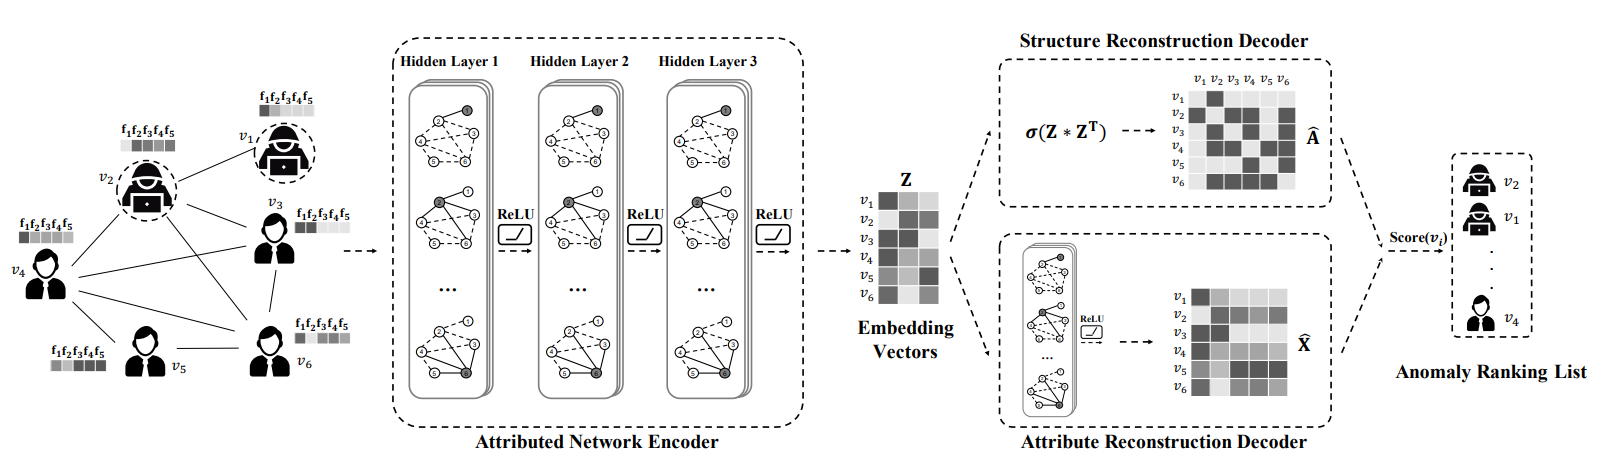

## Loss

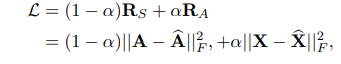

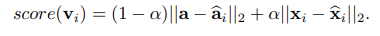

In [ ]:
#

## 3.1. Benchmarks

https://github.com/pygod-team/pygod/tree/main/benchmark  

Usage:  
python main.py [-h] [--model MODEL] [--gpu GPU] [--dataset DATASET]

In [ ]:
! python pygod/benchmark/main.py --dataset inj_cora --model dominant --gpu 0

  0% 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "
  5% 1/20 [00:13<04:18, 13.61s/it]/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "
 10% 2/20 [00:26<03:55, 13.06s/it]/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood samp

In [ ]:
! python pygod/benchmark/main.py --dataset inj_cora --model conad --gpu 0

## 3.2. PyGOD in notebook

Datasets description  
https://github.com/pygod-team/data  

### 3.2.1. Cora Injected

outliers were injected into Cora

In [ ]:
from pygod.utils import load_data

In [ ]:
data = load_data('inj_cora')
# - 0: inlier
# - 1: contextual outlier only
# - 2: structural outlier only
# - 3: both contextual outlier and structural outlier

In [ ]:
# labels count # число представителей класса
pd.Series(data.y.numpy()).value_counts()

0    2570
1      68
2      68
3       2
dtype: int64

In [ ]:
def calc_node_degree(data):
    s = pd.DataFrame(data.edge_index.numpy().T).groupby(0)[1].count()

    degree = np.zeros(data.x.shape[0],dtype=int)

    degree[s.index] = s.values

    return degree

In [ ]:
def print_roc_auc(data, score):
    if not isinstance(score,np.ndarray):
        score = score.numpy()

    structural_mask = np.isin(data.y.numpy(),([0,2,3]))
    contextual_mask = np.isin(data.y.numpy(),([0,1,3]))
    y = data.y.bool().numpy().astype(int)

    auc_structural =  roc_auc_score(y[structural_mask], score[structural_mask])
    auc_contextual =  roc_auc_score(y[contextual_mask], score[contextual_mask])
    auc_total = roc_auc_score(y, score)

    print("""ROC AUC structural = {:.3f}
ROC AUC contextual = {:.3f}
ROC AUC total      = {:.3f}
    """.format(auc_structural, auc_contextual, auc_total))

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
print('degree')
degree = calc_node_degree(data)
print_roc_auc(data, degree)

degree
ROC AUC structural = 0.959
ROC AUC contextual = 0.498
ROC AUC total      = 0.725
    


In [ ]:
import pyod

In [ ]:
# without graph
from sklearn.ensemble import IsolationForest
model = IsolationForest()
model.fit(data.x.numpy())
score = model.decision_function(data.x.numpy())
print('IsolationForest')
print_roc_auc(data, score)

IsolationForest
ROC AUC structural = 0.553
ROC AUC contextual = 0.767
ROC AUC total      = 0.657
    


In [ ]:
# without graph
from pyod.models.lof import LOF
model = LOF()
model.fit(data.x.numpy())
score = model.decision_function(data.x.numpy())
print('LOF')
print_roc_auc(data, score)

LOF
ROC AUC structural = 0.534
ROC AUC contextual = 0.871
ROC AUC total      = 0.699
    


In [ ]:
gpu = 0 # <=> cuda
# gpu = -1 # <=> cpu

In [ ]:
from pygod.detector import DOMINANT
model = DOMINANT(gpu=gpu)
model.fit(data)
score = model.decision_score_.numpy()
print('DOMINANT')
print_roc_auc(data, score)

DOMINANT
ROC AUC structural = 0.960
ROC AUC contextual = 0.581
ROC AUC total      = 0.767
    


In [ ]:
%%time
from pygod.detector import CONAD

model = CONAD(gpu=gpu)
model.fit(data)
score = model.decision_score_.numpy()
y =data.y.bool().numpy().astype(int)
print('CONAD')
print_roc_auc(data, score)

CONAD
ROC AUC structural = 0.962
ROC AUC contextual = 0.580
ROC AUC total      = 0.768
    
CPU times: user 10.3 s, sys: 27.8 ms, total: 10.3 s
Wall time: 10.5 s


In [ ]:
%%time
from pygod.detector import AnomalyDAE

model = AnomalyDAE()
model.fit(data)
score = model.decision_score_.numpy()
y =data.y.bool().numpy().astype(int)
print('AnomalyDAE')
print_roc_auc(data, score)

AnomalyDAE
ROC AUC structural = 0.510
ROC AUC contextual = 0.865
ROC AUC total      = 0.684
    
CPU times: user 1.48 s, sys: 22.4 ms, total: 1.5 s
Wall time: 1.57 s


In [ ]:
%%time
from pygod.detector import GAE

model = GAE(gpu=gpu)
model.fit(data)
score = model.decision_score_.numpy()
y =data.y.bool().numpy().astype(int)
print('GAE')
print_roc_auc(data, score)

### 3.2.2. Amazon Injected

outliers were injected into Amazon dataset

In [ ]:
data = load_data('inj_amazon')

# число представителей класса
pd.Series(data.y.numpy()).value_counts()

0    13058
1      344
2      344
3        6
dtype: int64

In [ ]:
degree = calc_node_degree(data)
print('degree')
print_roc_auc(data, degree)

degree
ROC AUC structural = 0.912
ROC AUC contextual = 0.506
ROC AUC total      = 0.707
    


In [ ]:
model = LOF()
model.fit(data.x.numpy())
score = model.decision_function(data.x.numpy())
print('LOF')
print_roc_auc(data, score)

LOF
ROC AUC structural = 0.484
ROC AUC contextual = 0.618
ROC AUC total      = 0.552
    


In [ ]:
model = IsolationForest()
model.fit(data.x.numpy())
score = model.decision_function(data.x.numpy())
print('IsolationForest')
print_roc_auc(data, score)

IsolationForest
ROC AUC structural = 0.528
ROC AUC contextual = 0.464
ROC AUC total      = 0.495
    


In [ ]:
%%time
from pygod.detector import AnomalyDAE

model = AnomalyDAE(gpu=gpu)

model.fit(data)
score = model.decision_score_.numpy()
y =data.y.bool().numpy().astype(int)
print('AnomalyDAE')
print_roc_auc(data, score)

AnomalyDAE
ROC AUC structural = 0.527
ROC AUC contextual = 0.981
ROC AUC total      = 0.752
    
CPU times: user 1.81 s, sys: 2.43 s, total: 4.24 s
Wall time: 4.26 s


In [ ]:
%%time
from pygod.detector import DOMINANT
model = DOMINANT(gpu=gpu)

model.fit(data)
score = model.decision_score_.numpy()
y = data.y.bool().numpy().astype(int)
print('DOMINANT')
roc_auc_score(y, score,)

DOMINANT
CPU times: user 37.2 s, sys: 42.2 s, total: 1min 19s
Wall time: 1min 21s


0.7188547063136183

In [ ]:
print_roc_auc(data, score)

ROC AUC structural = 0.920
ROC AUC contextual = 0.522
ROC AUC total      = 0.719
    


In [ ]:
model.

DOMINANT(act=<function relu at 0x7fdf5127f1c0>,
         backbone=<class 'torch_geometric.nn.models.basic_gnn.GCN'>,
         batch_size=13752, compile_model=False, contamination=0.1,
         dropout=0.0, epoch=100, gpu=None, hid_dim=64, lr=0.004,
         num_layers=4, num_neigh=[-1, -1, -1, -1], save_emb=False,
         sigmoid_s=False, verbose=0, weight=0.5, weight_decay=0.0)

In [ ]:
%%time
from pygod.detector import CONAD
model = CONAD(gpu=gpu)

model.fit(data)
score = model.decision_score_.numpy()
y = data.y.bool().numpy().astype(int)
print('CONAD')
roc_auc_score(y, score,)

### 3.2.3. weibo organic

Weibo has organic outliers

Dataset from  
Error-bounded graph anomaly loss for gnns.  
T. Zhao, C. Deng, K. Yu, T. Jiang, D. Wang, and M. Jiang.  
In Proceedings of the 29th ACM International Conference on Information & Knowledge Management, pages 1873–1882, 2020.  
https://tzhao.io/files/papers/CIKM20_GAL.pdf

Tencent-Weibo is a user-posts-hashtag graph from a Twitter-like
platform.  
It has 8,405 users  
There is an edge between 2 users if they used same hashtag in post  
100 location features   
300 bag-of-words features  

868 suspicious users and 7,537 benign

In [ ]:
data = load_data('weibo')

In [ ]:
describe_data(data)

Number of nodes: 8405
Number of edges: 407963
Number of features: 400
Number of classes: 2


In [ ]:
# Доли классов
pd.Series(data.y.numpy()).value_counts(normalize=True).round(3)

0    0.897
1    0.103
dtype: float64

In [ ]:
set(data.y.numpy())

{0, 1}

In [ ]:
degree = calc_node_degree(data)
print('degree')
roc_auc_score(data.y.numpy(), degree)

degree


0.11029787610002634

In [ ]:
1 - 0.11029787610002634

0.8897021238999736

In [ ]:
model = LOF()
model.fit(data.x.numpy())
score = model.decision_function(data.x.numpy())
print('LOF')
roc_auc_score(data.y.numpy(), score)

LOF


0.5646947409676013

In [ ]:
%%time
from pygod.detector import AnomalyDAE

model = AnomalyDAE(gpu=gpu)

model.fit(data)
score = model.decision_score_.numpy()
print('AnomalyDAE')
roc_auc_score(data.y.numpy(), score)

AnomalyDAE
CPU times: user 854 ms, sys: 939 ms, total: 1.79 s
Wall time: 1.8 s


0.7843462268171337

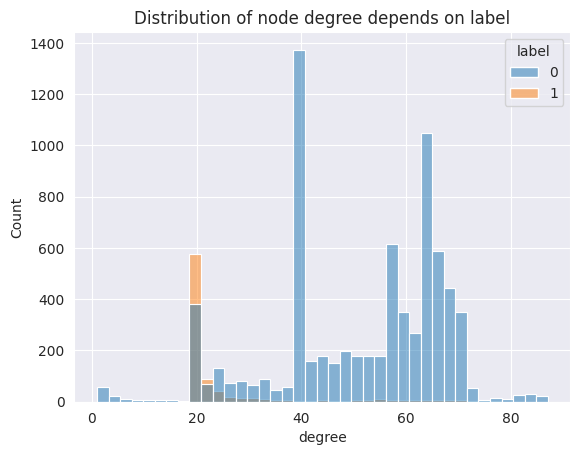

In [ ]:
d = pd.DataFrame([data.y.numpy(), degree]).T
d.columns = ['label','degree']
sns.histplot(data=d, x='degree', hue='label')#, stat="density", common_norm=False,
plt.title('Distribution of node degree depends on label');

In [ ]:
%%time
from pygod.detector import CONAD
model = CONAD(gpu=gpu)

model.fit(data)
score = model.decision_score_.numpy()
print('CONAD')
roc_auc_score(data.y.numpy(), score)

CONAD
CPU times: user 58.1 s, sys: 27.2 s, total: 1min 25s
Wall time: 1min 26s


0.9151453444115021

In [ ]:
%%time
from pygod.detector import DOMINANT
model = DOMINANT(gpu=gpu)

model.fit(data)
score = model.decision_score_.numpy()
y = data.y.bool().numpy().astype(int)
print('DOMINANT')
roc_auc_score(y, score)

In [ ]:
%%time
from pygod.detector import Radar
model = Radar(gpu=gpu)

model.fit(data)
score = model.decision_score_.numpy()
print('Radar')
roc_auc_score(data.y.numpy(), score)

Radar
CPU times: user 10.7 s, sys: 666 ms, total: 11.3 s
Wall time: 15.5 s


0.9845192289467201

## 3.3. Metric comparison of algorithms

https://www.cs.cmu.edu/~zhihaoj2/papers/Bond_NeurIPS22.pdf